In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import matplotlib.patches as patches

In [2]:
from IPython.display import display, clear_output
import random
class DynamicMazeTreasureHunt(gym.Env):
    def __init__(self):
        super(DynamicMazeTreasureHunt, self).__init__()

        # Define action and observation spaces, gym.space objects

        self.action_space = spaces.Discrete(6)

        #assuming each robot's field of view can contain up to 10 objects
        # each object is represented by a tuple (object_type, distance, angle)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,shape = (10,3))

        # Initialize state
        self.grid_size = (7,7)
        self.grid = np.zeros(self.grid_size)
        self.robot_position = (0,0)
        self.energy = 100
        self.treasure_positions = [(2,1)]
        self.trap_positions = [(1,2)]
        self.max_energy = 100
        self.heading = 180


        #initialize rewards
        self.treasure_reward = 500
        self.trap_reward = -100
        self.living_cost_reward = -1
        self.discovery_reward = 1 #not currently used

    def step(self, action):
        # Execute one time step within the environment

        # update robot position based on action
        if action == 0:  # up
            self.robot_position = (max(0, self.robot_position[0]-1), self.robot_position[1])
            self.heading = 90
        elif action == 1:  # down
            self.robot_position = (min(self.grid_size[0]-1, self.robot_position[0]+1), self.robot_position[1])
            self.heading = 270
        elif action == 2:  # left
            self.robot_position = (self.robot_position[0], max(0, self.robot_position[1]-1))
            self.heading = 180
        elif action == 3:  # right
            self.robot_position = (self.robot_position[0], min(self.grid_size[1]-1, self.robot_position[1]+1))
            self.heading = 0
        elif action == 4:  # turn right
            self.heading = ((self.heading - 90) + 360) % 360
        elif action == 5:  # turn left
            self.heading = ((self.heading + 90) + 360) % 360

        # decrease energy
        self.energy -= 1

        # check for treasure
        ran_out_of_energy = False

        if self.robot_position in self.treasure_positions:
            self.energy = self.max_energy # replenish energy for reaching a treasure position
            reward = self.treasure_reward
            terminated = True  # Reset the episode because the treasure was found
            self.treasure_positions.remove(self.robot_position)  # Remove the treasure from the environment
            print('treasure')
        elif self.robot_position in self.trap_positions:
            self.energy -= 70 # decrease energy
            reward = self.trap_reward
            self.trap_positions.remove(self.robot_position)  # Remove the trap from the environment
            terminated = self.energy <= 0
        else:
            reward = self.living_cost_reward
            terminated = self.energy <= 0 #check if the episode is done, if the robot has run out of energy
            if terminated:
                ran_out_of_energy = True
        if ran_out_of_energy: # only do this penalty if termination was related to running out of energy
            reward = -100

        #update obersvation
        #TODO: Implement method to create observation based on current starte and partial observability
        observation = self.get_observation()
        #print("reward:")
        #print(reward)
        #print("energy:")
        #print(self.energy)



        info = {}

        return observation, reward, terminated, info
    
    def reset(self):
        # Reset the state of the environment to an initial state
        #print('reset')
        self.robot_position = (0,0)
        self.heading = 180 #facing right at the start
        self.energy = self.max_energy

        # Randomize positions of treasure and trap
        possible_positions = [(i, j) for i in range(self.grid_size[0]) for j in range(self.grid_size[1]) 
                            if (i, j) != self.robot_position]
        self.treasure_positions = [random.choice(possible_positions)]
        possible_positions.remove(self.treasure_positions[0])  # Remove treasure position from possible positions
        self.trap_positions = [random.choice(possible_positions)]

        return self.get_observation()

    def render(self, mode='human'):
        if mode == 'human':
            clear_output(wait=True)  # Clear the previous image
            img = np.zeros(self.grid_size)  # This creates a 2D array of zeros with the same dimensions as the grid
            img[self.robot_position] = 1  # Set the robot position to 1
            for pos in self.treasure_positions:  # Set the treasure positions to 2
                img[pos] = 2
            for pos in self.trap_positions:  # Set the trap positions to 3
                img[pos] = 3
            plt.imshow(img, cmap='viridis', origin='lower')  # Create an image from the array
            # Add an arrow to indicate the robot's heading
            # Convert heading to radians
            heading_rad = np.deg2rad(self.heading)
            # Calculate the arrow direction
            dx = np.cos(heading_rad)
            dy = np.sin(heading_rad)
            # Plot the arrow
            plt.quiver(self.robot_position[1], self.robot_position[0], dx, dy*-1, color='red', scale=10, scale_units='inches')
            plt.show()  # Display the image
            display(plt.gcf())  # Display the current figure
        elif mode == 'rgb_array':
            # For rgb_array mode, you would return the image as an RGB array
            # This is typically used for recording videos or other post-processing
            pass

    #view size either 180 or 360
    def check_in_view(self, angle_relative, view_size):

        if view_size != 360:
            # Normalize angle_relative to be within [0, 360] range
            angle_relative = (angle_relative + 360) % 360

            # Check if the cell is within the 180-degree field of view in front of the agent
            if self.heading == 0:  # Facing right
                in_view = (angle_relative <= 90 or angle_relative >= 270)
            elif self.heading == 90:  # Facing down
                in_view = (angle_relative >= 180 and angle_relative <= 360)
            elif self.heading == 180:  # Facing left
                in_view = (angle_relative >= 90 and angle_relative <= 270)
            elif self.heading == 270:  # Facing up
                in_view = (angle_relative >= 0 and angle_relative <= 180)
            
            return in_view
        else:
            return True    

    def get_observation(self):
        # Initialize an empty list for the objects in the field of view
        objects_in_view = []

        # Initialize list to keep track of obstructed views
        obstructed_angles = []

        # Iterate over each cell in the grid
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                # Calculate distance and angle to the cell from the robot's position
                distance = np.sqrt((i-self.robot_position[0])**2 + (j-self.robot_position[1])**2)
                angle = np.arctan2(j-self.robot_position[1], i-self.robot_position[0]) * 180 / np.pi
                angle_relative = (self.heading - angle) % 360


                in_view = self.check_in_view(angle_relative, 180) #180 field of view, in front of robot

                
                # Check if the cell is in the field of view
                #field of view definition
                if in_view:
                    # Calculate the angles to the corners of the cell
                    angles_to_corners = [np.arctan2(corner[1]-self.robot_position[1], corner[0]-self.robot_position[0]) * 180 / np.pi for corner in [(i, j), (i+1, j), (i, j+1), (i+1, j+1)]]
                    
                    # Calculate the min and max angle to the cell
                    min_angle, max_angle = min(angles_to_corners), max(angles_to_corners)
                    
                    # Check if the view to the cell is obstructed
                    if any(min_angle <= obstructed <= max_angle for obstructed in obstructed_angles):
                        continue
                        
                    # If the cell contains an object, add it to the list of objects in view and mark the view as obstructed
                    min_angle = int(min_angle) 
                    max_angle = int(max_angle)

                    if (i, j) in self.treasure_positions:
                        objects_in_view.append(('treasure', distance, angle_relative))
                        obstructed_angles.extend(range(min_angle, max_angle+1))
                    elif (i, j) in self.trap_positions:
                        objects_in_view.append(('trap', distance, angle_relative))
                        obstructed_angles.extend(range(min_angle, max_angle+1))

        # If there are less than 10 objects in view, pad the list with 'empty' objects
        while len(objects_in_view) < 10:
            objects_in_view.append(('empty', 0.0, 0.0))

        # Convert the list of objects in view to a numpy array and return it
        return np.array(objects_in_view, dtype=[('object_type', 'U10'), ('distance', float), ('angle', float)])


        

In [3]:
import torch
import torch.nn as nn

class LSTMDQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMDQN, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(1, self.hidden_dim),
                torch.zeros(1, self.hidden_dim))

    def forward(self, x):
        x, new_hidden = self.lstm(x.view(len(x), -1), self.hidden)
        self.hidden = (new_hidden[0].detach(), new_hidden[1].detach())
        x = self.fc(x.view(len(x), -1))
        return x
    
    def reset_hidden(self):
        self.hidden = self.init_hidden()

In [4]:
import torch.optim as optim

class Agent:
    def __init__(self, input_dim, hidden_dim, output_dim, action_space_n):
        self.model = LSTMDQN(input_dim, hidden_dim, output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()
        self.action_space_n = action_space_n
        self.gamma = 0.9 #is this a good value????

    def choose_action(self, state, epsilon):

        # convert state to state_tensor
        object_type_dict = {'empty': 0, 'treasure': 1, 'trap': 2}
        state_numerical = np.array([[object_type_dict[obj['object_type']], obj['distance'], obj['angle']] for obj in state])
        state_flat = state_numerical.flatten().astype(float)
        state_tensor = torch.from_numpy(state_flat).float().view(1, -1)


        if np.random.random() < epsilon:
            return np.random.choice(a=range(self.action_space_n)) #choose a random action (epsilon decay)
        else:
            with torch.no_grad():
                return torch.argmax(self.model(state_tensor)).item() #choose an action according to the model

    def update(self, state, action, reward, next_state):

        # Assuming that an 'empty' object is represented by (0, 0.0, 0.0) for (object_type, distance, angle)
        # where object_type for 'empty' is 0, 'treasure' is 1, and 'trap' is 2
        object_type_dict = {'empty': 0, 'treasure': 1, 'trap': 2}

        # Convert structured array to a regular array with numerical data only
        state_numerical = np.array([[object_type_dict[obj['object_type']], obj['distance'], obj['angle']] for obj in state])
        next_state_numerical = np.array([[object_type_dict[obj['object_type']], obj['distance'], obj['angle']] for obj in next_state])

        # Flatten the array and convert to float
        state_flat = state_numerical.flatten().astype(float)
        next_state_flat = next_state_numerical.flatten().astype(float)

        # Convert to PyTorch tensors
        state_tensor = torch.from_numpy(state_flat).float().view(1, -1)
        next_state_tensor = torch.from_numpy(next_state_flat).float().view(1, -1)

        # Get the current Q-values for all actions
        current_q_values = self.model(state_tensor)

        # Get the Q-value for the action taken
        current_q_value = current_q_values[0][action]

        # Calculate the target Q-value
        next_q_values = self.model(next_state_tensor)
        max_next_q_value = next_q_values.max(1)[0].detach()
        expected_q_value = reward + (self.gamma * max_next_q_value)  # assuming gamma is your discount factor

        # calculate loss - the target Q-value should be detached from the graph as it's a target
        loss = self.criterion(current_q_value.unsqueeze(0), expected_q_value)
        
        # backpropagate loss
        self.optimizer.zero_grad()
        loss.backward() 
        self.optimizer.step() #update model weights
        #self.model.reset_hidden()  # Reset the hidden state after backpropagation- stupid????

In [5]:
import time
def train(agent, env, episodes, epsilon_decay):
    epsilon = 1.0
    total_rewards = []
    for episode in range(episodes):
        print(episode)
        state = env.reset()
        agent.model.reset_hidden()  # Reset the hidden state at the start of each episode
        done = False
        total_reward = 0
        while not done:
            action = agent.choose_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state

            total_reward += reward
            #env.render() # Comment out if no render durining training


        epsilon *= epsilon_decay
        total_rewards.append(total_reward)
    return total_rewards

        


0
1
treasure
2
3
4
5
6
7
treasure
8
9
10
11
12
13
14
treasure
15
treasure
16
17
18
19
20
21
treasure
22
23
24
25
treasure
26
27
28
29
treasure
30
31
treasure
32
33
treasure
34
treasure
35
36
37
38
39
40
treasure
41
42
43
44
45
46
treasure
47
48
treasure
49
50
51
treasure
52
treasure
53
treasure
54
55
treasure
56
57
treasure
58
59
60
61
62
63
64
65
66
treasure
67
68
69
70
71
72
treasure
73
treasure
74
75
76
treasure
77
78
79
80
81
82
83
84
85
treasure
86
87
88
treasure
89
treasure
90
91
92
93
94
95
96
treasure
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
treasure
115
116
117
118
119
120
121
122
123
124
treasure
125
126
127
128
129
130
treasure
131
132
133
134
135
136
137
138
139
140
141
142
143
treasure
144
145
146
147
148
149
150
151
152
153
154
155
156
treasure
157
158
159
treasure
160
161
treasure
162
163
164
165
166
167
168
169
treasure
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
treasure
187
treasure
188
189
190
191
192
193
treasure
1

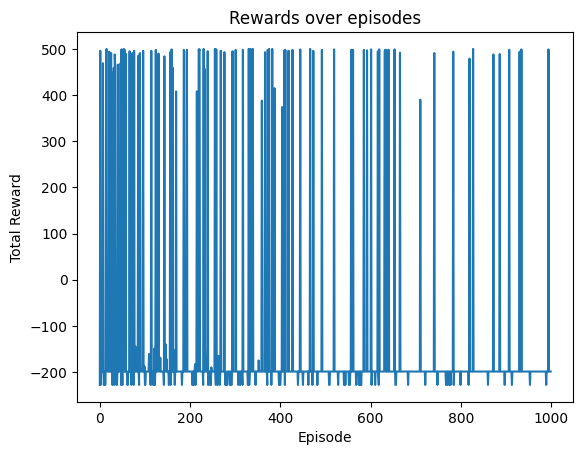

[-228, 496, -228, -187, -199, -174, -199, 469, -199, -228, -199, -199, -228, -199, 491, 500, -159, -199, -186, -199, -199, 494, -199, -145, -199, 491, -199, -199, -228, 450, -199, 459, -228, 488, 466, -199, -199, -228, -228, -199, 466, -199, -199, -199, -199, -199, 469, -228, 499, -154, -228, 482, 479, 500, -199, 498, -199, 490, -199, -199, -199, -228, -228, -199, -199, -199, 495, -199, -199, -199, -228, -199, 491, 482, -199, -228, 496, -199, -199, -145, -199, -199, -199, -182, -199, 485, -199, -228, 490, 491, -199, -199, -199, -199, -199, -189, 496, -199, -199, -188, -228, -228, -199, -199, -199, -199, -199, -199, -199, -161, -199, -199, -228, -228, 496, -199, -199, -199, -228, -199, -228, -149, -228, -199, 498, -199, -199, -199, -199, -134, 490, -199, -199, -199, -169, -199, -199, -199, -199, -199, -199, -199, -228, 484, -199, -199, -140, -199, -172, -199, -199, -199, -199, -228, -199, -199, 493, -228, -199, 499, -199, 460, -199, -199, -152, -199, -228, -199, -199, 408, -199, -199, -

In [6]:
# Initialize the environment        
env = DynamicMazeTreasureHunt()

# Initialize the agent
input_dim = 30 # 10 objects * 3 attributes per object
hidden_dim = 10 # arbitrary number for the hidden dimensions
output_dim = env.action_space.n # number of available actions
agent = Agent(input_dim, hidden_dim, output_dim, env.action_space.n)

# Train the agent
episodes = 1000
epsilon_decay = 0.98
rewards = train(agent, env, episodes, epsilon_decay)
torch.save(agent.model.state_dict(), 'lstm_dqn_model7.pth')

# Plot the rewards
plt.plot(rewards)
plt.title('Rewards over episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()
print(rewards)

import csv

# Save rewards to CSV
with open('rewards7.csv', 'w', newline='') as csvfile:
    reward_writer = csv.writer(csvfile)
    for reward in rewards:
        reward_writer.writerow([reward])

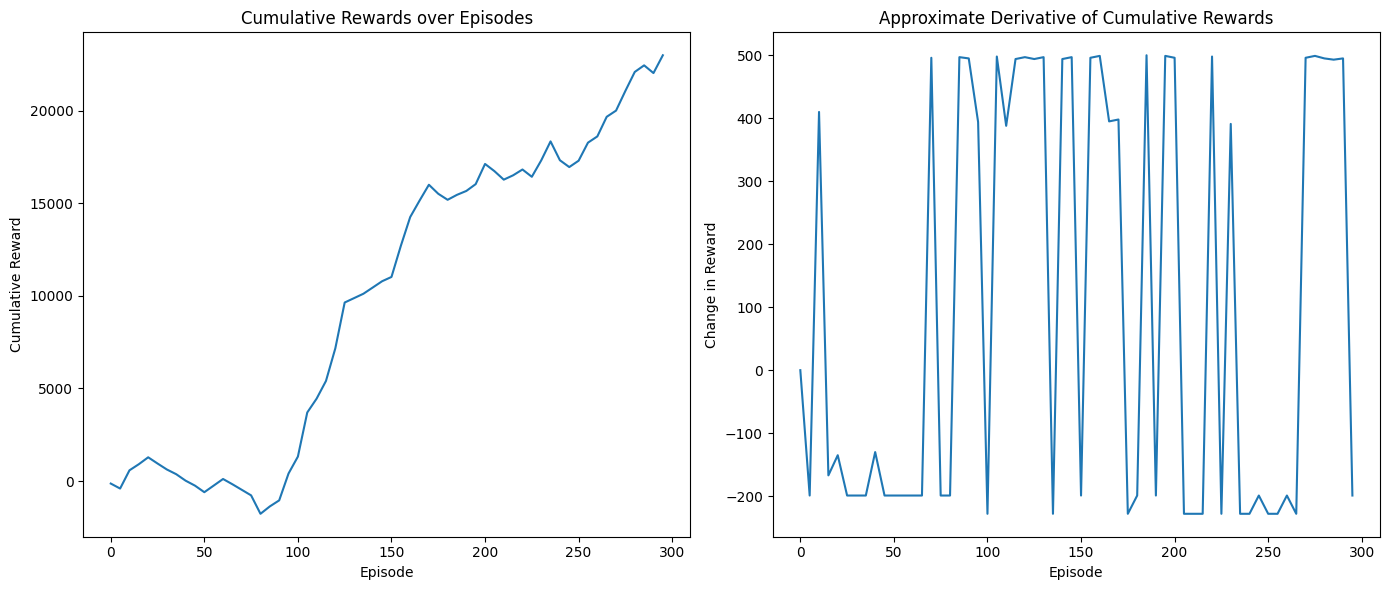

In [9]:


import csv
import pandas as pd

# Read rewards from CSV
df = pd.read_csv('rewards6.csv', header=None, names=['Reward'])

# Calculate the cumulative sum of the rewards
df['CumulativeReward'] = df['Reward'].cumsum()

# Calculate the approximate derivative of the cumulative rewards
df['RewardChange'] = df['CumulativeReward'].diff().fillna(0)

# Downsample the data to have a data point every 10 episodes for the cumulative rewards
df_downsampled_cumulative = df['CumulativeReward'].iloc[::5]

# Downsample the data to have a data point every 10 episodes for the reward change
df_downsampled_change = df['RewardChange'].iloc[::5]

# Plot the cumulative rewards
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df_downsampled_cumulative.index, df_downsampled_cumulative)
plt.title('Cumulative Rewards over Episodes')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

# Plot the derivative of the cumulative rewards
plt.subplot(1, 2, 2)
plt.plot(df_downsampled_change.index, df_downsampled_change)
plt.title('Approximate Derivative of Cumulative Rewards')
plt.xlabel('Episode')
plt.ylabel('Change in Reward')

plt.tight_layout()
plt.show()

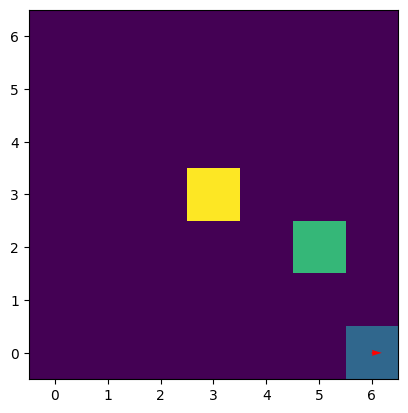

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [137]:
import time

model = LSTMDQN(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('lstm_dqn_model5.pth'))
model.eval()  # Set the model to evaluation mode

def evaluate(agent, env, episodes, visual):
    total_rewards = []
    for episode in range(episodes):
        print(episode)
        state = env.reset()
        agent.model.reset_hidden()  # Reset the hidden state at the start of each episode
        done = False
        total_reward = 0
        while not done:
            action = agent.choose_action(state, epsilon=0)  # No randomness, choose best action
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if visual:
                #time.sleep(0.05)
                env.render()
        #print('end reward:')
        #print(total_reward)
        total_rewards.append(total_reward)
    return total_rewards

import matplotlib.pyplot as plt

# Evaluate the model
num_episodes_evaluated = 300
rewards = evaluate(agent, env, episodes=num_episodes_evaluated, visual=True)  # Evaluate for a certain number of episodes

good_rewards_count = 0
for reward in rewards:
    if reward > 50:
        good_rewards_count += 1

# Plot the rewards
plt.plot(rewards)
plt.title('Rewards over episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()
print(rewards)
print('good %')
print(good_rewards_count/num_episodes_evaluated * 100)